# Project 03 - 3D reconstruction

In this project, you will work on 3D reconstruction from stereo data.
You will estimate disparity maps from rectified images, and resolve inconsistencies in the results using graphical models.

For this task, you will use the [2014 Stereo Datasets](https://vision.middlebury.edu/stereo/data/scenes2014/).
The dataset contains rectified images and serves as a benchmark for depth estimation from stereo images.

1. Download the dataset and inspect its structure.
1. Choose at least two images from the dataset to work with. For the beginning, work with the default images (no variation in lightning or exposure).
1. Use the methods discussed in the lecture to compute the disparity between the two images, which involves:
    1. Scanline approach to identify matching pixels using an appropriate similarity metric.
    1. Cross-checking using reverse scanline.
    1. Resolution of ambiguous matches.
1. Use the computed disparity to estimate the depth.
1. Repeat the above steps using the provided images with varying lightning and exposure.
1. Use a Markov Random Field (MRF) to resolve holes and inaccuracies in the computed disparity maps.
    1. Install [gco-wrapper](https://github.com/Borda/pyGCO) using `pip install gco-wrapper`.
    1. Convert the task of smoothing the disparity map into a MRF problem. In particular, think about how labels can be defined for this task (tip: maximum disparity).
    1. Use `cut_grid_graph` or `cut_grid_graph_simple` to solve the defined MRF.
1. Recompute the depth map using your corrected disparity maps and compare them to the previous result. Repeat the analysis for your selected images under different lightning and exposure.

__Tip:__ Do not replicate your code, use functions to repeat the analysis on different image pairs.

In [ ]:
!pip install gco-wrapper

In [ ]:
from torchvision.datasets import Middlebury2014Stereo
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from gco import cut_grid_graph_simple

In [ ]:
from skimage.transform import resize

def norm_img(img):
  return (img-img.mean(axis = (0,1), keepdims = True))/img.std(axis = (0,1), keepdims = True)
  # return (img-img.min(axis = (0,1), keepdims = True))/img.max(axis = (0,1), keepdims = True)

def unnorm_img(img):
  shifted_img = img+abs(img.min())
  return shifted_img/shifted_img.max()

def stereo_resize(imgs, dsp_maps, valid_masks):
  img_left, img_right = imgs
  img_left, img_right = img_left.copy(), img_right.copy()
  dsp_map_left, dsp_map_right = dsp_maps

  max_size = (512, 512)
  img_left.thumbnail(max_size), img_right.thumbnail(max_size)
  dsp_map_left, dsp_map_right = resize(dsp_map_left.squeeze(), img_left.size[::-1]), resize(dsp_map_right.squeeze(), img_right.size[::-1])
  valid_mask_left, valid_mask_right = (dsp_map_left>0), (dsp_map_right>0)
  img_left, img_right = np.array(img_left), np.array(img_right)
  img_left, img_right = norm_img(img_left), norm_img(img_right)

  return (img_left, img_right), (dsp_map_left, dsp_map_right), (valid_mask_left, valid_mask_right)

In [ ]:
dataset = Middlebury2014Stereo(root = './data', transforms = stereo_resize, download = True)

(353, 512, 3)


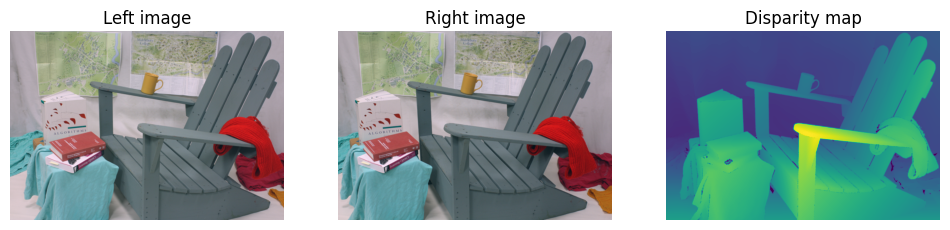

In [ ]:
img_left, img_right, dsp_map, val_mask = dataset[0]
print(img_left.shape)
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(unnorm_img(img_left))
plt.axis('off')
plt.title("Left image")
plt.subplot(1,3,2)
plt.imshow(unnorm_img(img_right))
plt.axis('off')
plt.title("Right image")
plt.subplot(1,3,3)
plt.imshow(dsp_map)
plt.axis('off')
plt.title("Disparity map")
plt.show()

In [ ]:
def patchify(img, block_size,):
  padded_image = np.pad(img, ((block_size, block_size), (block_size, block_size), (0, 0)), mode='constant')
  patches = np.lib.stride_tricks.sliding_window_view(padded_image, (2*block_size+1, 2*block_size+1, 3)).squeeze()
  return patches

#fast but takes a lot of RAM
def get_disp_map_old(img_left, img_right, block_size, disp_range, reverse = True):
  #get patches
  left_patches = patchify(img_left, block_size)
  right_patches = patchify(img_right, block_size)
  #calculate indices
  h, w = img_left.shape[:2]
  disp_arr = np.zeros((h, w, disp_range))
  width_ind = np.arange(w)
  disps = np.arange(-disp_range//2, disp_range//2 + 1)
  shifted_ind = np.clip(width_ind[:, None] + disps, 0, w-1)
  #calculate diferences
  diffs = (np.abs(left_patches[:, width_ind][:, :, None, ...]-right_patches[:, shifted_ind[width_ind]]))
  #calculate disparities using SAD
  disp_arr = diffs.sum(axis = (3, 4, 5))
  if reverse:
    disp_map = disp_range-disp_arr.argmin(2)
  else:
    disp_map = disp_arr.argmin(2)
  return disp_map, disp_arr

#slower, but memory-friendly version
def get_disp_map(img_left, img_right, block_size, disp_range, reverse = True):
  #get patches
  left_patches = patchify(img_left, block_size)
  right_patches = patchify(img_right, block_size)
  #calculate indices
  h, w = img_left.shape[:2]

  width_ind = np.arange(w)
  disps = np.arange(-disp_range//2, disp_range//2 + 1)
  disp_arr = np.zeros((h, w, len(disps)))
  #calculate diferences
  for i, delta in enumerate(tqdm(disps)):
    shifted_ind = np.clip(width_ind + delta, 0, w-1)
    diffs = (np.abs(left_patches[:, width_ind]-right_patches[:, shifted_ind]))
    disp_arr[:, :, i] = diffs.sum(axis = (2, 3, 4))
  if reverse:
    disp_map = disp_range-disp_arr.argmin(2)
  else:
    disp_map = disp_arr.argmin(2)
  return disp_map, disp_arr

In [ ]:
block_size = 4
disp_range = 150

In [ ]:
disp_map_left, disp_arr_left = get_disp_map(img_left, img_right, block_size, disp_range)

  0%|          | 0/151 [00:00<?, ?it/s]

In [ ]:
disp_map_right, disp_arr_right = get_disp_map(img_right, img_left, block_size, disp_range, False)

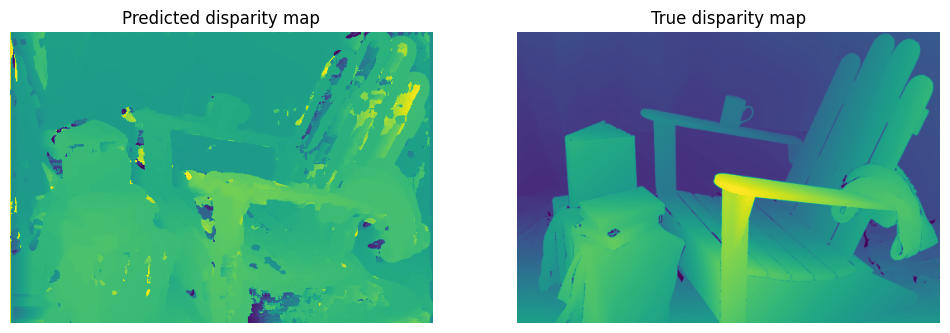

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(disp_map_left)
plt.axis('off')
plt.title("Predicted disparity map")
plt.subplot(1,2,2)
plt.imshow(dsp_map)
plt.axis('off')
plt.title("True disparity map")
plt.show()

## Testing

In [ ]:
def get_disp_map(img_left, img_right, block_size, disp_range):
  x_max, y_max = img_left.shape[:2]
  pad = disp_range + block_size
  img_left_pad = np.full((x_max + 2*pad, y_max+2*pad, 3), 255)
  img_left_pad[pad: pad+x_max, pad: pad+y_max] = img_left
  img_right_pad = np.full((x_max + 2*pad, y_max+2*pad, 3), 255)
  img_right_pad[pad: pad+x_max, pad: pad+y_max] = img_right
  disp_arr = np.zeros((x_max, y_max, disp_range))
  for x in tqdm(range(pad, pad+x_max)):
    for y in tqdm(range(pad, pad+y_max), leave = False):
      x_left, x_right, y_down, y_up = x-block_size, x+block_size, y-block_size, y+block_size
      left_block = img_left_pad[x_left: x_right, y_down: y_up]
      for disp in range(-disp_range//2, disp_range//2):
        x_left_, x_right_, y_down_, y_up_ =  x_left + disp, x_right + disp, y_down, y_up #max(y_left + disp, 0), min(y_right + disp, y_max)
        right_block = img_right_pad[x_left_: x_right_, y_down_: y_up_]
        try:
          score = np.abs((left_block-right_block)).sum()
        except:
          print((x, y, disp), (x_left_, x_right_, y_down_, y_up_), left_block.shape, right_block.shape, sep ='\n')
          raise IndexError('Wrong shapes!')
        disp_arr[x-pad, y-pad, disp+disp_range//2] = score
  return disp_arr

In [ ]:
def get_disp_map(img1, img2, patch_size, max_disparity):
    m = max_disparity  # max disparity
    s = patch_size//2

    h, w, _ = img1.shape
    disparity_map = np.zeros((h, w), dtype=np.float32)

    for k in tqdm(range(s, h - s)):
        for j in range(s, w - s):
            patch1 = img1[k - s: k + s + 1, j - s: j + s + 1]
            best_disparity = 255
            best_corr = np.inf
            for i in range(max(s, j - m), min(w - s, j + m)):
                patch2 = img2[k - s: k + s + 1, i - s: i + s + 1]
              # corr = normalized_cross_correlation(patch1, patch2)
                corr = np.sum(np.abs(patch1 - patch2))
                if corr < best_corr:
                    best_corr = corr
                    best_disparity = j - i

            disparity_map[k, j] = best_disparity

    return disparity_map

In [ ]:
disp_arr_left_double = get_disp_map(img_left, img_right, block_size, disp_range)
# disp_arr_right = get_disp_map(img_right, img_left, block_size, disp_range)

  0%|          | 0/175 [00:00<?, ?it/s]

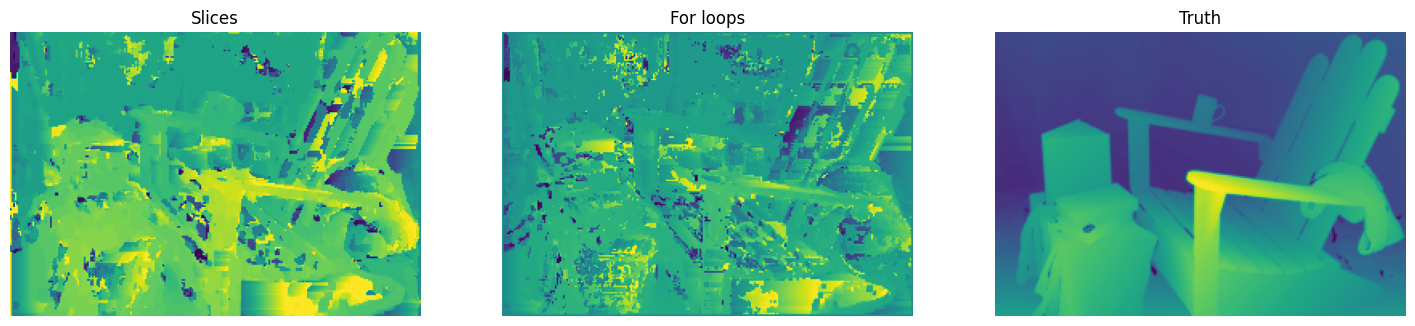

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(1,3,1)
plt.imshow(disp_map_left)
plt.axis('off')
plt.title("Slices")
plt.subplot(1,3,2)
plt.imshow(disp_arr_left_double)
plt.axis('off')
plt.title("For loops")
plt.subplot(1,3,3)
plt.imshow(dsp_map)
plt.axis('off')
plt.title("Truth")
plt.show()

In [ ]:
def remove_outliers(disp_map_left, disp_map_right, disp_range, tol = 5):
    ind = np.indices(disp_map_left.shape)
    shift_ind = np.clip(ind[1] + (disp_map_right-disp_range//2), 0, disp_map_left.shape[1]-1)
    disp_map_left_align = disp_map_left[ind[0], shift_ind]

    mask = (disp_map_left_align-tol <= disp_map_right) & (disp_map_left_align+tol >= disp_map_right)
    outliers = np.zeros_like(disp_map_right)
    # outliers[mask] = np.maximum(disp_map_right[mask], disp_map_left_align[mask])
    # outliers[~mask] = np.minimum(disp_map_right[~mask], disp_map_left_align[~mask])
    outliers[mask] = disp_map_right[mask]
    return outliers

In [ ]:
outliers = remove_outliers(disp_map_left, disp_map_right, disp_range, tol = 10)
# outliers = remove_outliers(disp_map_right, disp_map_left, disp_range, tol = 10)

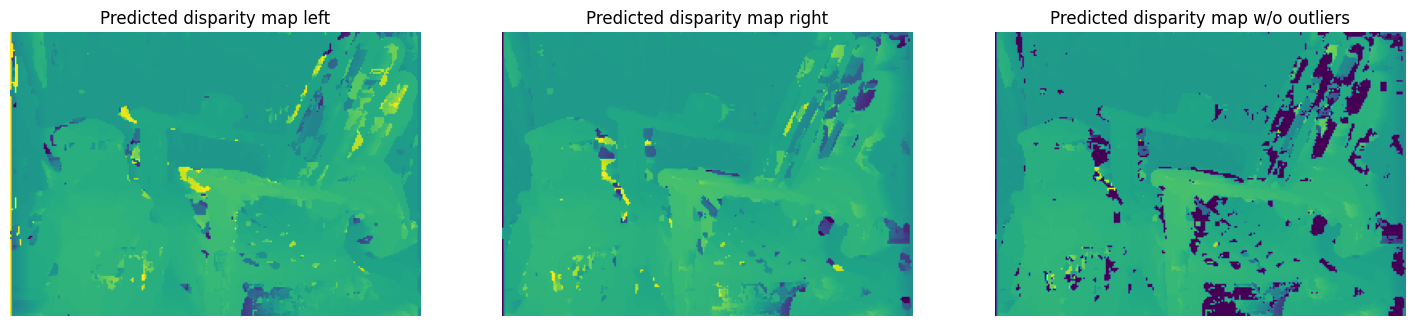

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(1,3,1)
plt.imshow(disp_map_left)
plt.axis('off')
plt.title("Predicted disparity map left")
plt.subplot(1,3,2)
plt.imshow(disp_map_right)
plt.axis('off')
plt.title("Predicted disparity map right")
plt.subplot(1,3,3)
plt.imshow(outliers)
plt.axis('off')
plt.title("Predicted disparity map w/o outliers")
plt.show()

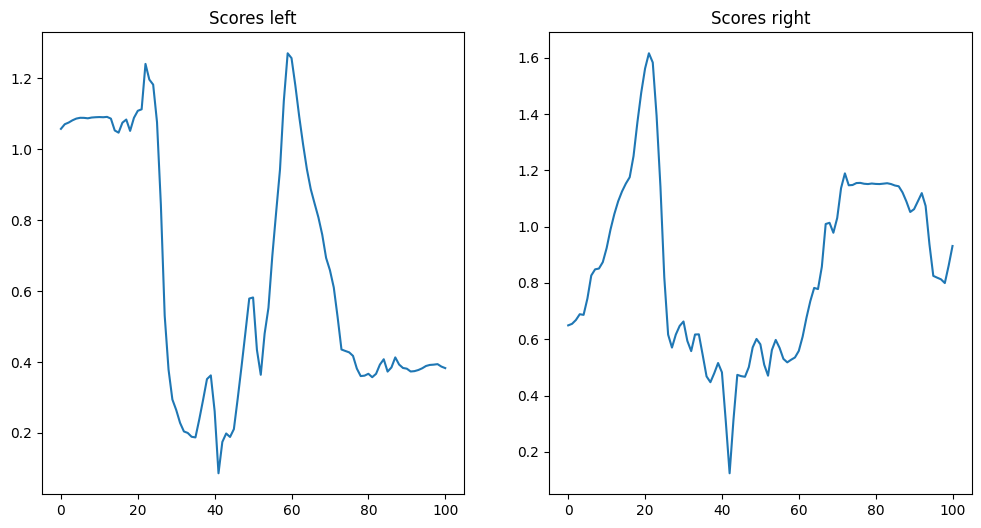

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(disp_arr_left[100,100])
plt.title("Scores left")
plt.subplot(1,2,2)
plt.plot(disp_arr_right[100,100, ::-1])
plt.title("Scores right")
plt.show()

## MRF

In [ ]:
h,w = disp_map_left.shape
pairwise = (1 - np.eye(disp_range+1)).astype('int32')

In [ ]:
deltas = disp_arr_left- disp_arr_right[..., ::-1]
mask = abs(deltas)<=0.75*np.max(deltas)
outliers = np.ones_like(disp_arr_left)
outliers[mask] = disp_arr_left[mask]
outliers= outliers.astype('int32')

In [ ]:
labels = cut_grid_graph_simple(outliers.astype('int32'), pairwise, n_iter=100).reshape(h,w)

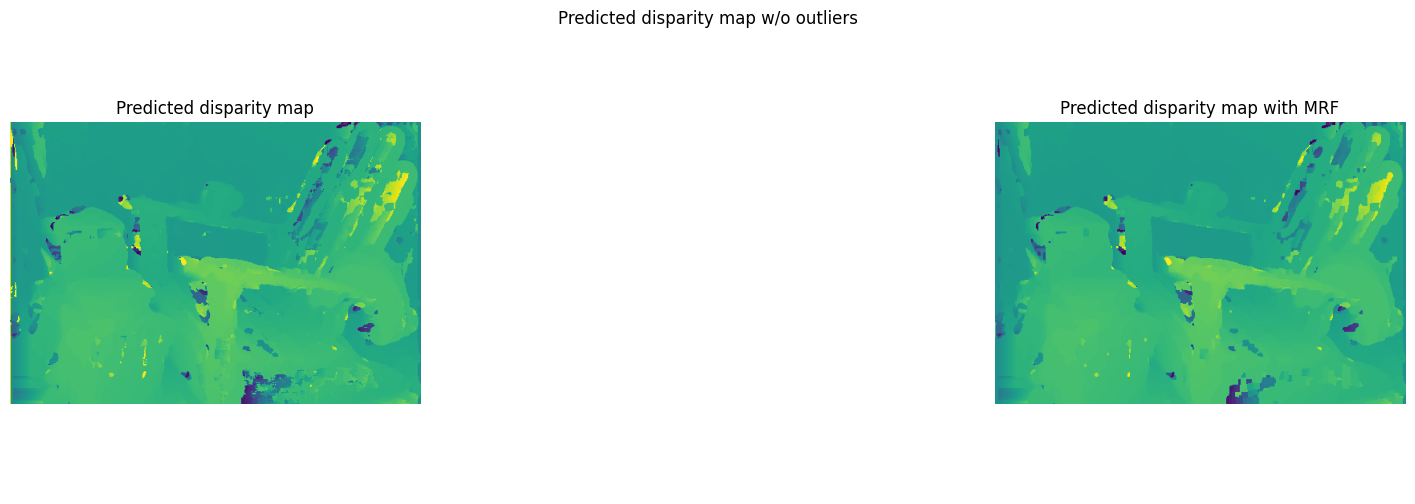

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(1,3,1)
plt.imshow(disp_map_left)
plt.axis('off')
plt.title("Predicted disparity map")
plt.subplot(1,3,2)
plt.imshow(disp_range - outliers.argmin(2))
plt.axis('off')
plt.title("Predicted disparity map w/o outliers")
plt.subplot(1,3,3)
plt.imshow(disp_range - labels)
plt.axis('off')
plt.title("Predicted disparity map with MRF")
plt.show()

## Final result

In [ ]:
#Sampling of different exposures enabled
dataset = Middlebury2014Stereo(root = './data', transforms = stereo_resize, use_ambient_views=True, download = True)

  0%|          | 0/151 [00:00<?, ?it/s]

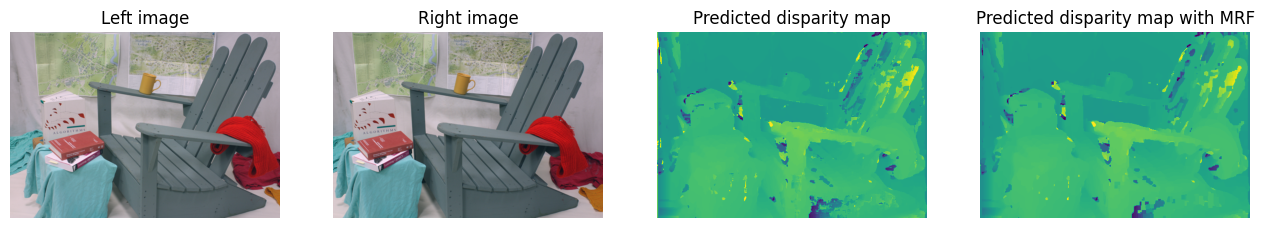

  0%|          | 0/151 [00:00<?, ?it/s]

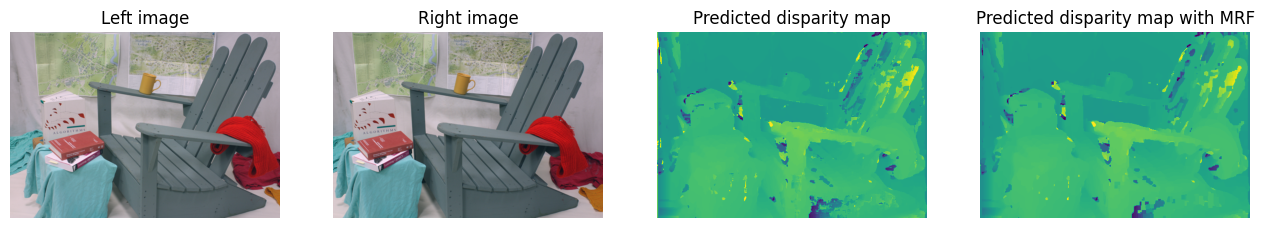

  0%|          | 0/151 [00:00<?, ?it/s]

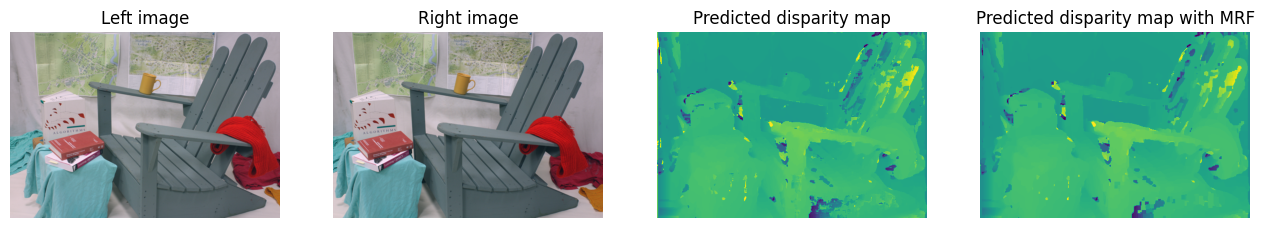

  0%|          | 0/151 [00:00<?, ?it/s]

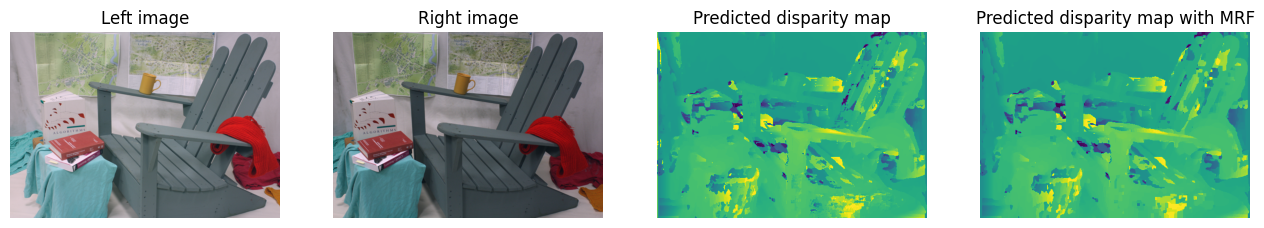

In [ ]:
block_size = 4
disp_range = 150
pairwise = (1 - np.eye(disp_range+1)).astype('int32')
for i in range(4):
  img_left, img_right, dsp_map, val_mask = dataset[0]
  disp_map_left, disp_arr_left = get_disp_map(img_left, img_right, block_size, disp_range)
  h,w = disp_map_left.shape
  labels = cut_grid_graph_simple(disp_arr_left.astype('int32'), pairwise, n_iter=100).reshape(h,w)
  plt.figure(figsize=(16, 4))
  plt.subplot(1,4,1)
  plt.imshow(unnorm_img(img_left))
  plt.axis('off')
  plt.title("Left image")
  plt.subplot(1,4,2)
  plt.imshow(unnorm_img(img_right))
  plt.axis('off')
  plt.title("Right image")
  plt.subplot(1,4,3)
  plt.imshow(disp_map_left)
  plt.axis('off')
  plt.title("Predicted disparity map")
  plt.subplot(1,4,4)
  plt.imshow(disp_range - labels)
  plt.axis('off')
  plt.title("Predicted disparity map with MRF")
  plt.show()